<a href="https://colab.research.google.com/github/tiffduong/Data_Science_Portfolio/blob/master/Final_Project_Dog_Breed_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Recognition
###### A convolutional neural network trained with Keras and Tensorflow, test completed using the edge based device Intel Movidius Neural Compute Stick 2. Dataset used for training originated from Kaggle's [Dog Breed Identification competition](https://www.kaggle.com/c/dog-breed-identification/data)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Packages

In [0]:
# import packages
import os
import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# make graphs pretty in ipynb notebooks
%matplotlib inline

RANDOM_SEED = 9999

# ignore warnings
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

## Data Exploration

In [0]:
# paths to train/test folders
train = '/content/drive/My Drive/MSDS 462/Dog_Recognition/train'
test = '/content/drive/My Drive/MSDS 462/Dog_Recognition/test'

# load in train labels csv
train_csv = pd.read_csv('/content/drive/My Drive/MSDS 462/Dog_Recognition/labels.csv')

In [4]:
# get quick stats from the train labels csv
train_df = pd.DataFrame(train_csv)

print('There are {} images in the training set.'.format(train_df.shape[0]))
print('There are {} breeds(labels) in the training set.'.format(len(train_df['breed'].unique())))

There are 10222 images in the training set.
There are 120 breeds(labels) in the training set.


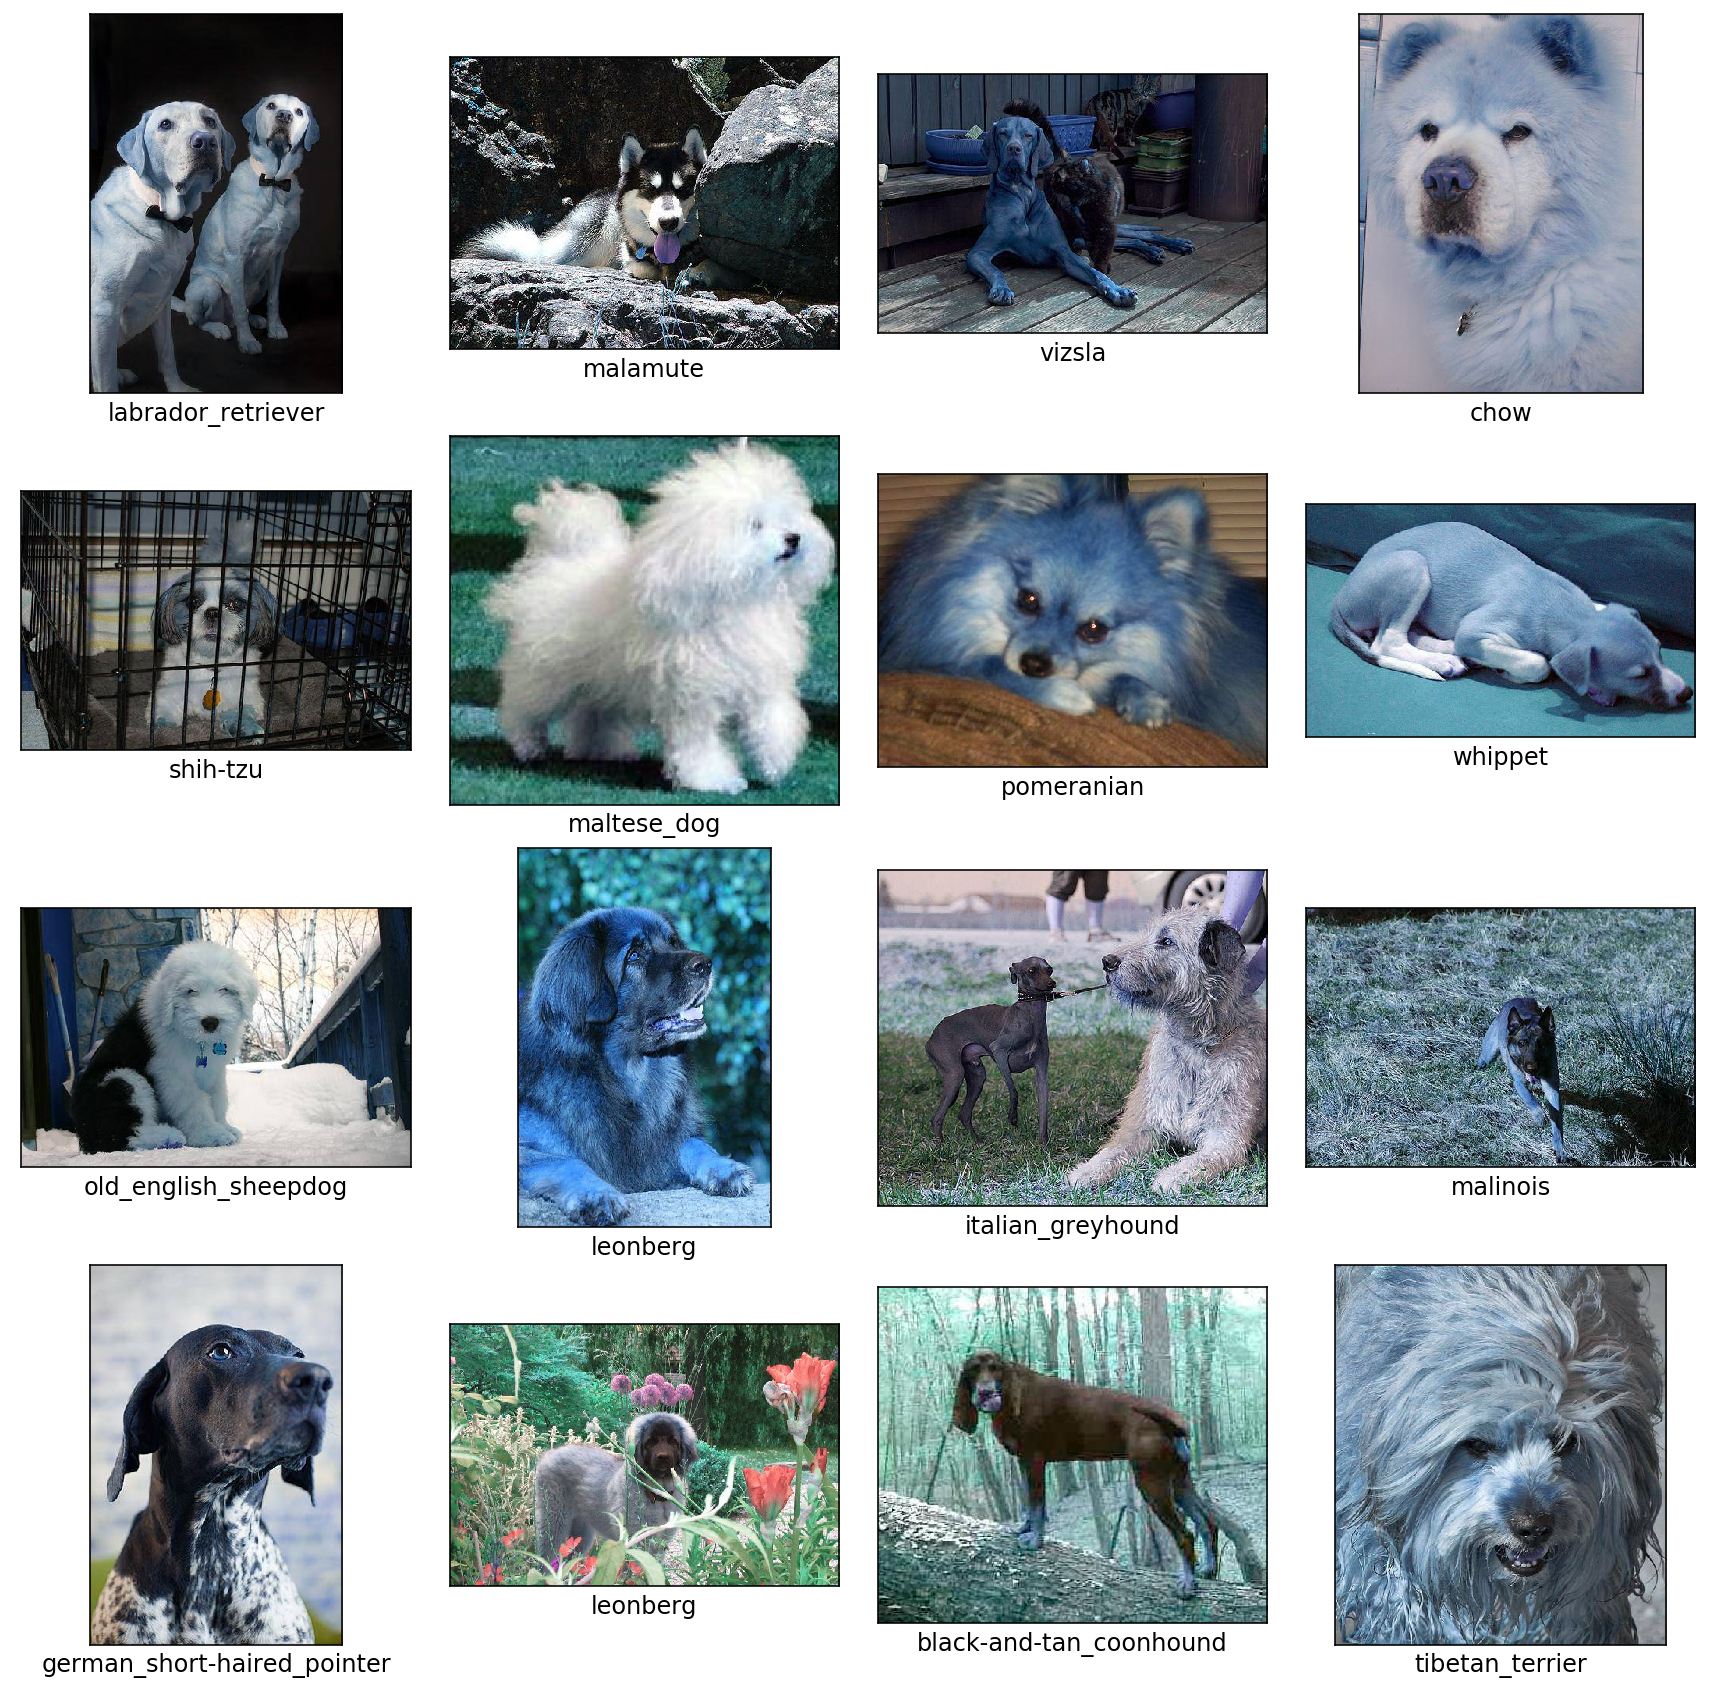

In [53]:
directory = '/content/drive/My Drive/MSDS 462/Dog_Recognition'

# display images from the training set
fig, axs = plt.subplots(4,4, figsize=(15,15), squeeze=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axs = axs.reshape(-1)
indices = np.random.choice(train_df.shape[0], 25, replace=False)
for ax, i in zip(axs, indices):
    img = cv2.imread(os.path.join(directory, 'train', train_df.iloc[i].id + '.jpg'))
    h, w, c = img.shape
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(train_df.iloc[i].breed, fontsize=12)
    ax.imshow(img)

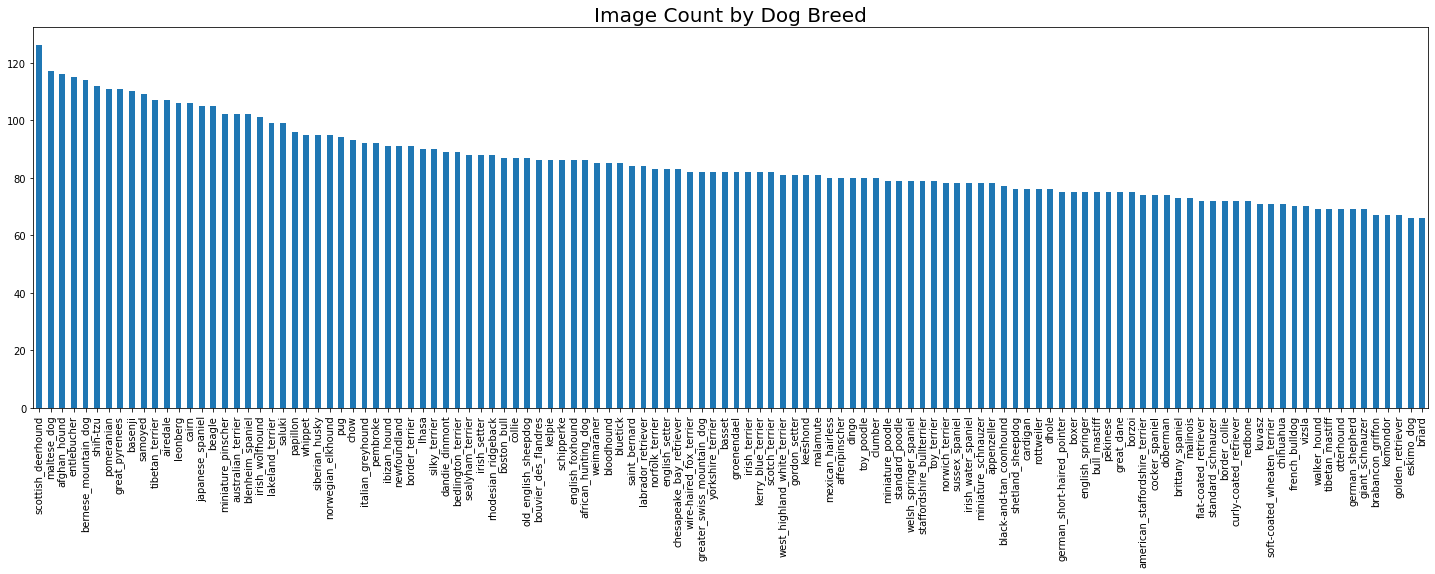

In [5]:
# see if a certain breed is overrepresented
plt.rcParams["figure.figsize"] = (25,7)
plt.title('Image Count by Dog Breed', fontsize = 20)

breed_count = pd.value_counts(train_df['breed']).plot.bar()

## Data Preparation

In [0]:
# turn breed names into a series of targets
targets = pd.Series(train_df['breed'])
one_hot = pd.get_dummies(targets, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [25]:
# create empty lists and initialize loop i
im_size = 128
X_train = []
y_train = []
X_test = []
i = 0 

# append train labels to resized image (128, 128) - done in atom due to file order issues
#for f, breed in tqdm_notebook(train_df.values):
#  img = cv2.imread('/content/drive/My Drive/MSDS 462/Dog_Recognition/train/{}.jpg'.format(f))
#  label = one_hot_labels[i]
#  X_train.append(cv2.resize(img, (im_size, im_size)))
#  y_train.append(label)
#  i += 1

X_train = joblib.load('/content/drive/My Drive/MSDS 462/Dog_Recognition/X_train.sav')
y_train = joblib.load('/content/drive/My Drive/MSDS 462/Dog_Recognition/y_train.sav')

# preprocess arrays sp that image pixel values fall within range (0,1)
y_train_initial = np.array(y_train, np.uint8)
X_train_initial = np.array(X_train, np.float32) / 255.

num_class = y_train_initial.shape[1]

print(X_train_initial.shape)
print(y_train_initial.shape)

(10222, 128, 128, 3)
(10222, 120)


In [55]:
# split training images 80/20 for train/validation
X_train,X_val,y_train,y_val = train_test_split(
    X_train_initial, y_train_initial, test_size=0.2, random_state=RANDOM_SEED)

print('Training Shape: {} \nValidation Shape{}'.format(X_train.shape, X_val.shape))

Training Shape: (8177, 128, 128, 3) 
Validation Shape(2045, 128, 128, 3)
